### 1.Load data

In [1]:
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
adata = sc.read_h5ad('../data/train_pbmc.h5ad')
adata

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

In [2]:
adata = sc.AnnData(adata.X, obs=adata.obs.copy(), var=adata.var.copy())
adata.obs_names_make_unique()
print(adata)
print('\n', adata.obs['condition'].value_counts())
print('\n', adata.obs['cell_type'].value_counts())

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'

 stimulated    8886
control       8007
Name: condition, dtype: int64

 CD4T           5564
FCGR3A+Mono    3601
CD14+Mono      2561
B              1811
NK             1163
CD8T           1115
Dendritic      1078
Name: cell_type, dtype: int64


### 2.Build and train models

In [3]:
from scpram import models
model = models.SCPRAM(input_dim=adata.n_vars, device='cuda:0')
model = model.to(model.device)
# key_dic varies with the adata
key_dic = {'condition_key': 'condition',
           'cell_type_key': 'cell_type',
           'ctrl_key': 'control',
           'stim_key': 'stimulated',
           'pred_key': 'predict',
           }
cell_to_pred = 'CD4T'
# The training set does not contain the type of data to be predicted after the perturbation
train = adata[~((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
               (adata.obs[key_dic['condition_key']] == key_dic['stim_key']))]
model.train_SCPRAM(train, epochs=100)

Training Epoch 99: 100%|██████████| 100/100 [03:40<00:00,  2.20s/it, SCPRAM_loss=58.9, kl_loss=440, recon_loss=118]


### 3.Predict

In [4]:
adata_to_pred = adata[((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
                       (adata.obs[key_dic['condition_key']] == key_dic['ctrl_key']))]
pred = model.predict(train_adata=train,
                     cell_to_pred=cell_to_pred,
                     key_dic=key_dic,
                     ratio=0.005)  # The ratio need to vary with the size of dataset
print(pred)

AnnData object with n_obs × n_vars = 2437 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'


### 4.Evaluation

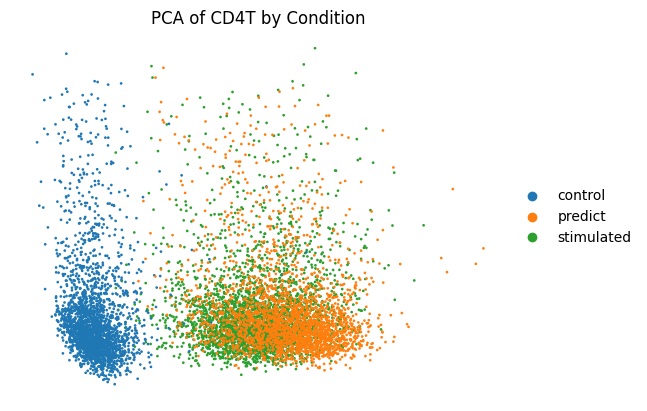

common DEGs:  56


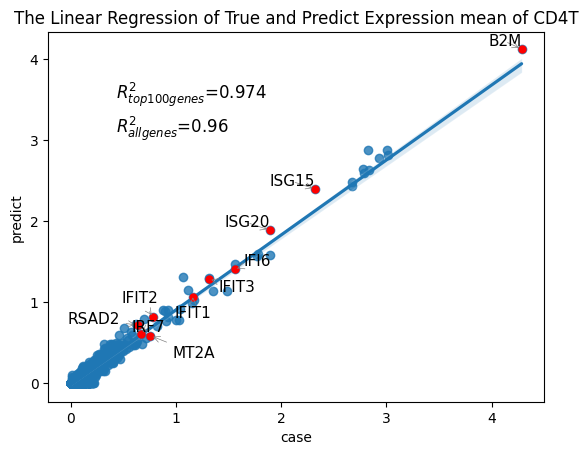

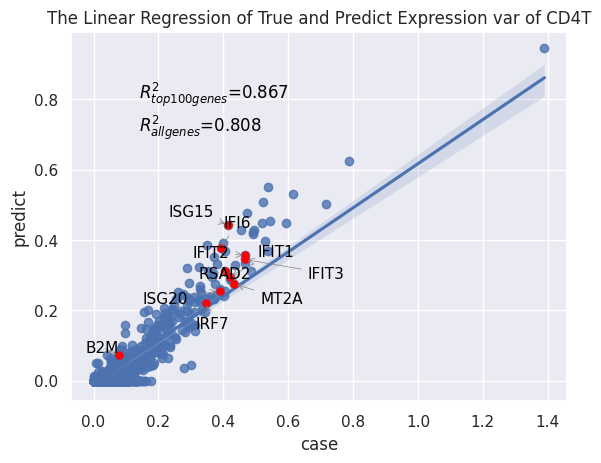

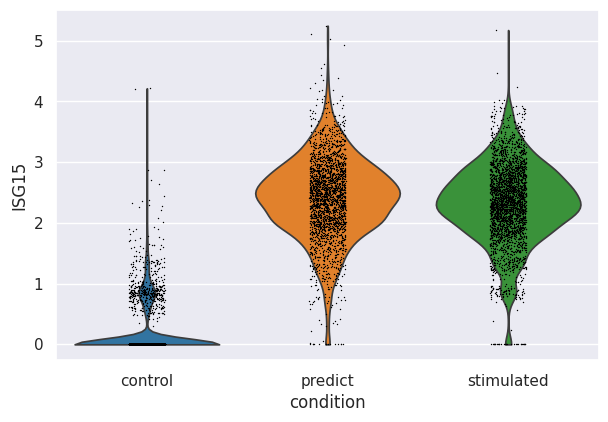

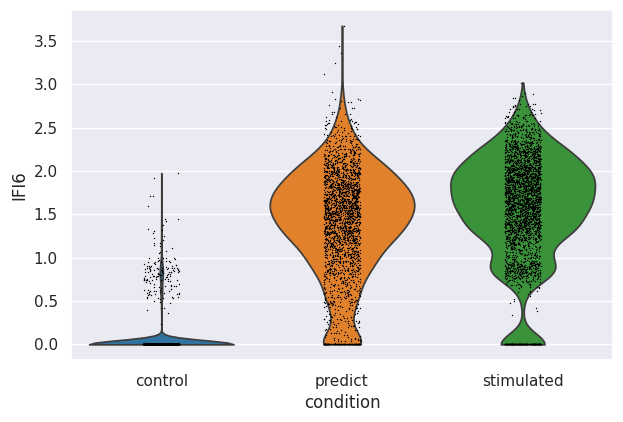

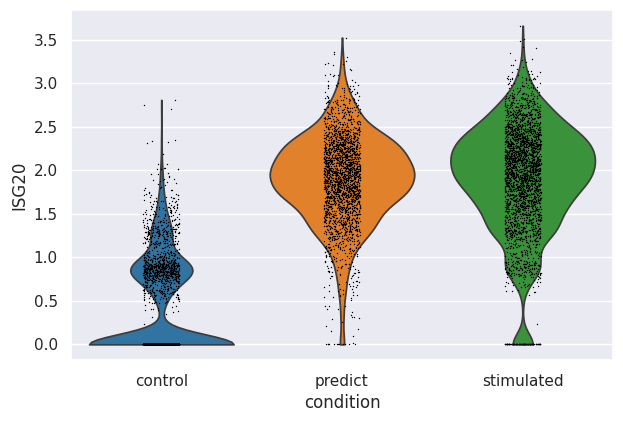

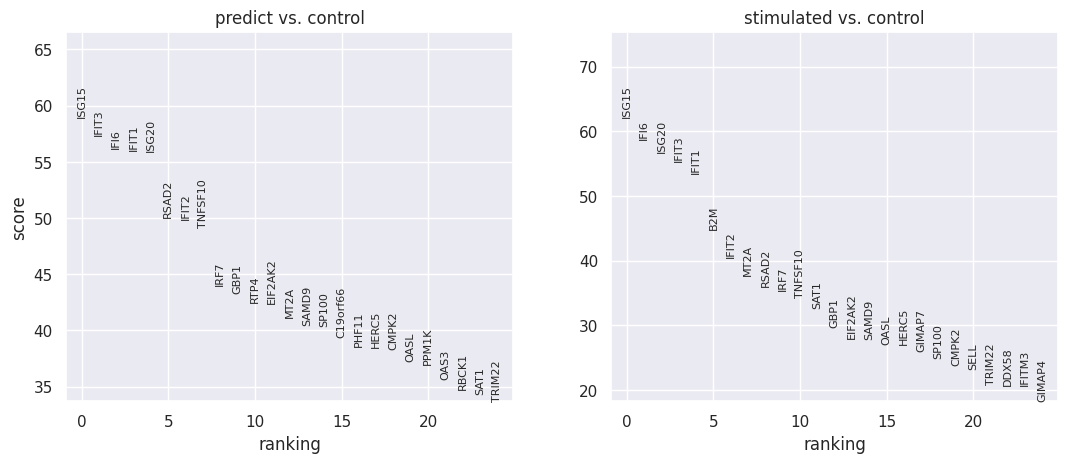

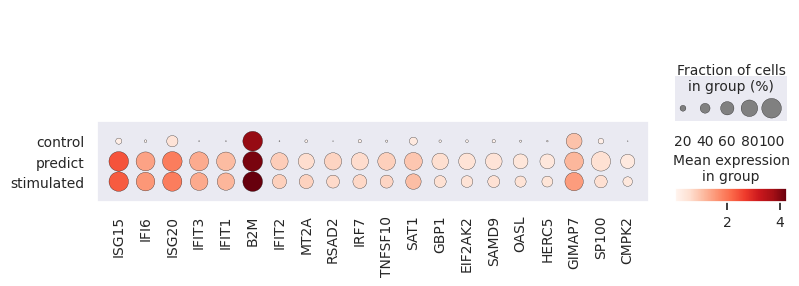

In [5]:
from scpram import evaluate
ground_truth = adata[(adata.obs[key_dic['cell_type_key']] == cell_to_pred)]
eval_adata = ground_truth.concatenate(pred)
evaluate.evaluate_adata(eval_adata=eval_adata, 
                        cell_type=cell_to_pred, 
                        key_dic=key_dic
                        )
